In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [2]:
#Reading the Dataset
df=pd.read_excel('/content/drive/MyDrive/bilayer GelMA study/Bilayer DS data_equal cell quantity.xlsx')
df.head()

,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz,Group,Day
0,0.533,0.273,0.354,0.090,0.134,0.057,-0.018,-0.025,-0.059,-0.233,-0.193,1.0,1.0
1,0.737,0.313,0.362,0.191,0.202,0.133,-0.056,-0.071,-0.071,-0.198,-0.115,1.0,1.0
2,0.755,0.561,0.393,-0.112,0.114,0.045,-0.072,-0.066,-0.060,-0.206,-0.123,1.0,1.0
3,0.714,0.146,0.510,0.058,0.196,0.074,-0.076,-0.109,-0.081,-0.239,-0.195,1.0,1.0
4,0.632,0.221,0.283,-0.085,0.211,0.028,-0.037,-0.069,-0.114,-0.259,-0.214,1.0,1.0


In [3]:
X=df[['Average Zeroed Cap@174kHz', 'Average Zeroed Cap@224kHz', 'Average Zeroed Cap@287kHz', 'Average Zeroed Cap@368kHz', 'Average Zeroed Cap@473kHz', 'Average Zeroed Cap@607kHz', 'Average Zeroed Cap@779kHz', 'Average Zeroed Cap@1000kHz', 'Average Zeroed Cap@1284kHz', 'Average Zeroed Cap@1648kHz', 'Average Zeroed Cap@2115kHz']]
Y=df[['Group','Day']]

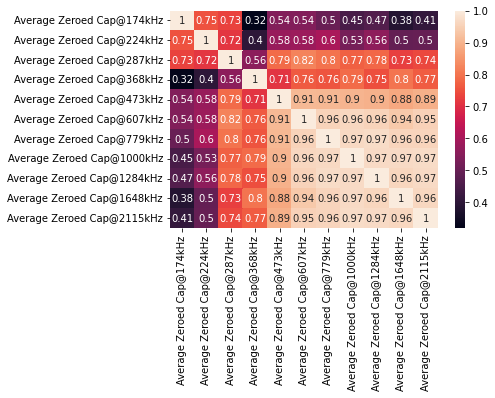

In [4]:
#Heatmap
sns.heatmap(X.corr(), annot=True);

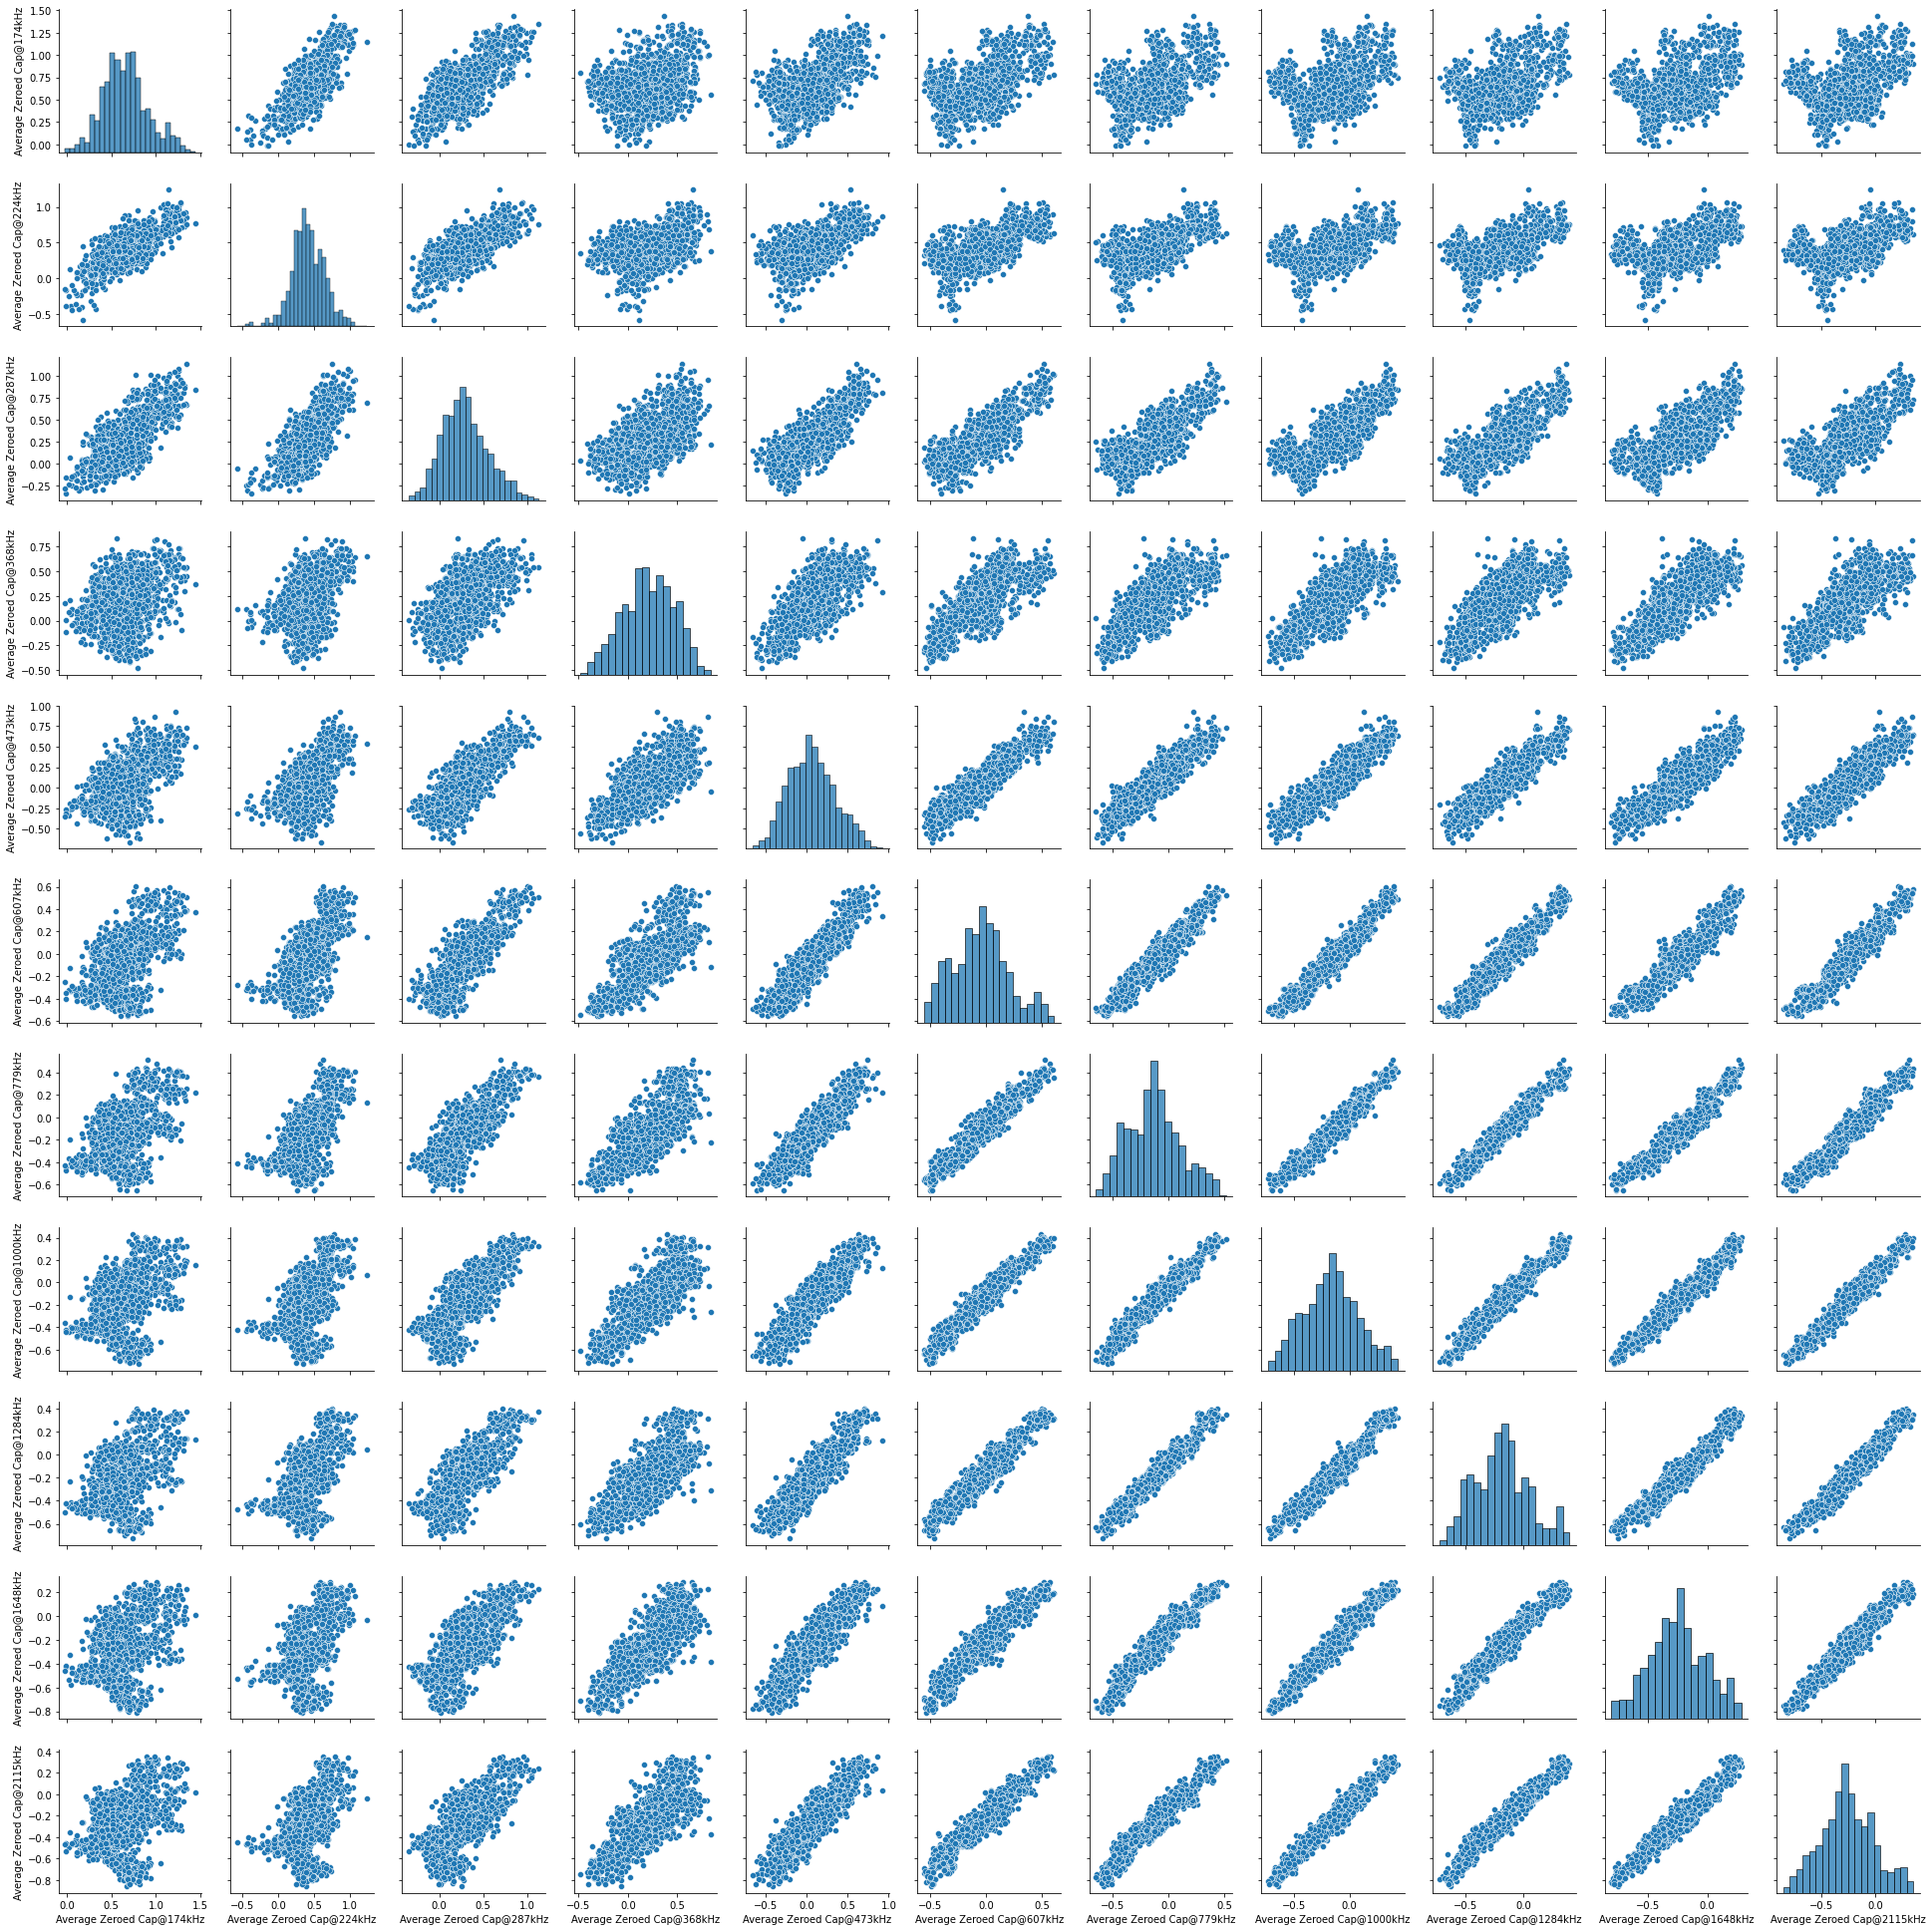

In [5]:
sns.pairplot(X)

In [6]:
# confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
#Grid search

def grid_search(clf, parameters, scorer, train_data, test_data, cv=5):

    #Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(train_data[0], train_data[1])

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(train_data[0], train_data[1])

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(train_data[0])
    best_test_predictions = best_clf.predict(test_data[0])

    # Calculate the acc score of the new model.
    print('The training acc Score is', accuracy_score(best_train_predictions, train_data[1]))
    print('The testing acc Score is', accuracy_score(best_test_predictions, test_data[1]))
    print('The testing acc Score STD', np.mean(grid_obj.cv_results_['std_test_score']))


    # Let's also explore what parameters ended up being used in the new model.
    return grid_obj, best_clf

Function of SML models

In [8]:
# Logistics Regression with cross validation
def logistic_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    parameters = {'C':[.5, 1.0, 5, 10, 100, 1000]}
    scorer = make_scorer(accuracy_score)
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10_000) 
    
    # grid search
    grid_obj, best_clf = grid_search(logreg, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [9]:
# Decision Tree Classification with cross validation
def dtree_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
    scorer = make_scorer(accuracy_score)


    # grid search
    grid_obj, best_clf = grid_search(dtree, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [10]:
# Support vector machine with cross validation
def svc_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    svc = SVC() 
    parameters = {'kernel':['rbf','linear'],'C':[0.1, 1, 10], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
    scorer = make_scorer(accuracy_score)
   

    # grisearch
    grid_obj, best_clf = grid_search(svc, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [11]:
# K Nearest Neighbours with cross validation
def knn_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    knn = KNeighborsClassifier()
    neighbors = list(range(1, 30))  
    parameters = {'n_neighbors': neighbors}
    scorer = make_scorer(accuracy_score)
 
    # grisearch
    grid_obj, best_clf = grid_search(knn, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [12]:
# Random Forest with cross validation
def rf_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    rf= RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(rf, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [13]:
# Naive Bayes with cross validation
def nb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    nb= GaussianNB()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(nb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [14]:
# XG Boosting Classifier with cross validation
def xgb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    xgb= XGBClassifier()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(xgb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

#Group Classification

In [18]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X,
                                                Y['Group'],
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y['Group'])


# create class names
class_names = np.unique(Y['Group'])
class_names = [c for c in class_names]

In [19]:
class_names

[1.0, 2.0, 3.0, 4.0]

The training acc Score is 0.5511904761904762
The testing acc Score is 0.5472222222222223
The testing acc Score STD 0.036230776672658706
              precision    recall  f1-score   support

         1.0       0.64      0.74      0.69        90
         2.0       0.60      0.72      0.66        90
         3.0       0.47      0.37      0.41        90
         4.0       0.41      0.36      0.38        90

    accuracy                           0.55       360
   macro avg       0.53      0.55      0.54       360
weighted avg       0.53      0.55      0.54       360



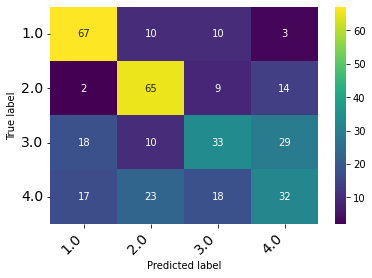

In [20]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.7833333333333333
The testing acc Score is 0.5972222222222222
The testing acc Score STD 0.03615640556426287
              precision    recall  f1-score   support

         1.0       0.70      0.79      0.74        90
         2.0       0.67      0.74      0.71        90
         3.0       0.59      0.38      0.46        90
         4.0       0.43      0.48      0.45        90

    accuracy                           0.60       360
   macro avg       0.60      0.60      0.59       360
weighted avg       0.60      0.60      0.59       360



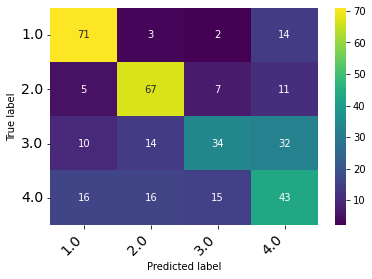

In [21]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.7583333333333333
The testing acc Score is 0.6888888888888889
The testing acc Score STD 0.03246188168827878
              precision    recall  f1-score   support

         1.0       0.80      0.82      0.81        90
         2.0       0.83      0.87      0.85        90
         3.0       0.57      0.61      0.59        90
         4.0       0.54      0.46      0.49        90

    accuracy                           0.69       360
   macro avg       0.68      0.69      0.68       360
weighted avg       0.68      0.69      0.68       360



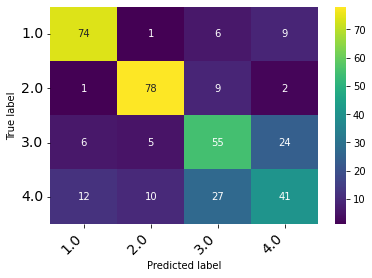

In [22]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.8178571428571428
The testing acc Score is 0.7777777777777778
The testing acc Score STD 0.04063428688527483
              precision    recall  f1-score   support

         1.0       0.84      0.90      0.87        90
         2.0       0.88      0.93      0.91        90
         3.0       0.64      0.72      0.68        90
         4.0       0.74      0.56      0.63        90

    accuracy                           0.78       360
   macro avg       0.78      0.78      0.77       360
weighted avg       0.78      0.78      0.77       360



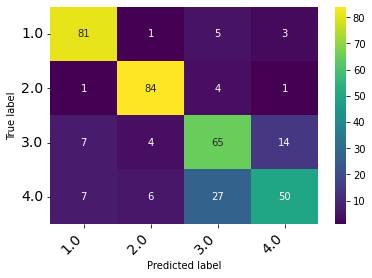

In [23]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9940476190476191
The testing acc Score is 0.7444444444444445
The testing acc Score STD 0.02651316363252393
              precision    recall  f1-score   support

         1.0       0.81      0.83      0.82        90
         2.0       0.83      0.89      0.86        90
         3.0       0.68      0.66      0.67        90
         4.0       0.64      0.60      0.62        90

    accuracy                           0.74       360
   macro avg       0.74      0.74      0.74       360
weighted avg       0.74      0.74      0.74       360



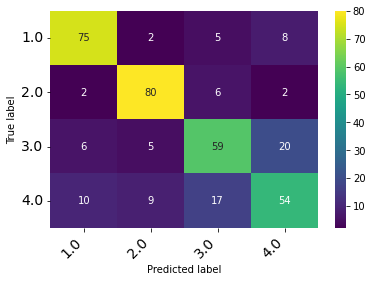

In [24]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.43452380952380953
The testing acc Score is 0.42777777777777776
The testing acc Score STD 0.015338212769910854
              precision    recall  f1-score   support

         1.0       0.55      0.50      0.52        90
         2.0       0.47      0.60      0.53        90
         3.0       0.34      0.46      0.39        90
         4.0       0.33      0.16      0.21        90

    accuracy                           0.43       360
   macro avg       0.42      0.43      0.41       360
weighted avg       0.42      0.43      0.41       360



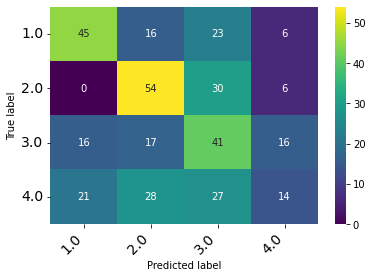

In [25]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9023809523809524
The testing acc Score is 0.6972222222222222
The testing acc Score STD 0.04367603887581942
              precision    recall  f1-score   support

         1.0       0.78      0.79      0.78        90
         2.0       0.74      0.87      0.80        90
         3.0       0.63      0.62      0.63        90
         4.0       0.61      0.51      0.56        90

    accuracy                           0.70       360
   macro avg       0.69      0.70      0.69       360
weighted avg       0.69      0.70      0.69       360



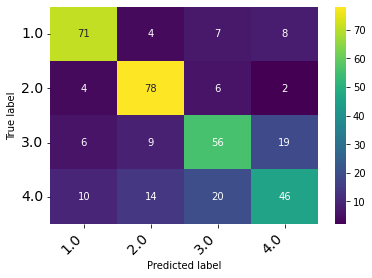

In [26]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 10)

#Time Duration Analysis

In [30]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X,
                                                Y['Day'],
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y['Day'])


# create class names
class_names = np.unique(Y['Day'])
class_names = [c for c in class_names]

The training acc Score is 0.8952380952380953
The testing acc Score is 0.8944444444444445
The testing acc Score STD 0.01282758926535008
              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98        72
         4.0       0.86      0.79      0.83        72
         7.0       0.89      0.86      0.87        72
        10.0       0.84      0.97      0.90        72
        13.0       0.91      0.86      0.89        72

    accuracy                           0.89       360
   macro avg       0.90      0.89      0.89       360
weighted avg       0.90      0.89      0.89       360



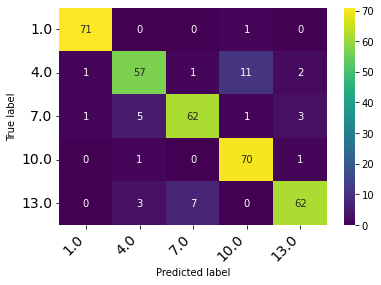

In [31]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9047619047619048
The testing acc Score is 0.75
The testing acc Score STD 0.025651949316315696
              precision    recall  f1-score   support

         1.0       0.86      0.92      0.89        72
         4.0       0.63      0.60      0.61        72
         7.0       0.70      0.68      0.69        72
        10.0       0.81      0.78      0.79        72
        13.0       0.74      0.78      0.76        72

    accuracy                           0.75       360
   macro avg       0.75      0.75      0.75       360
weighted avg       0.75      0.75      0.75       360



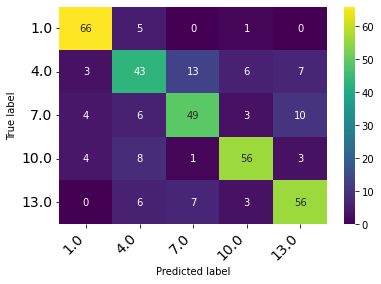

In [32]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.919047619047619
The testing acc Score is 0.9083333333333333
The testing acc Score STD 0.016130263491517687
              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98        72
         4.0       0.90      0.83      0.86        72
         7.0       0.89      0.89      0.89        72
        10.0       0.85      0.96      0.90        72
        13.0       0.94      0.88      0.91        72

    accuracy                           0.91       360
   macro avg       0.91      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360



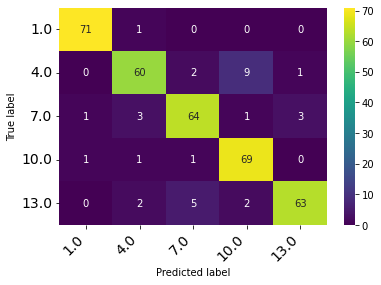

In [33]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.8964285714285715
The testing acc Score is 0.875
The testing acc Score STD 0.015814158617811755
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96        72
         4.0       0.81      0.81      0.81        72
         7.0       0.85      0.85      0.85        72
        10.0       0.87      0.96      0.91        72
        13.0       0.89      0.81      0.85        72

    accuracy                           0.88       360
   macro avg       0.88      0.88      0.87       360
weighted avg       0.88      0.88      0.87       360



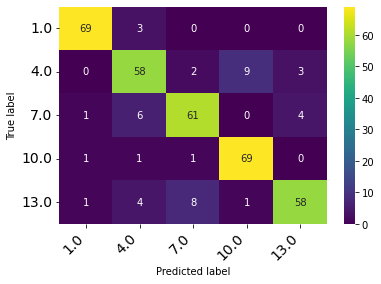

In [34]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9952380952380953
The testing acc Score is 0.825
The testing acc Score STD 0.03312006605534177
              precision    recall  f1-score   support

         1.0       0.92      0.92      0.92        72
         4.0       0.72      0.76      0.74        72
         7.0       0.84      0.74      0.79        72
        10.0       0.86      0.90      0.88        72
        13.0       0.79      0.81      0.80        72

    accuracy                           0.82       360
   macro avg       0.83      0.82      0.82       360
weighted avg       0.83      0.82      0.82       360



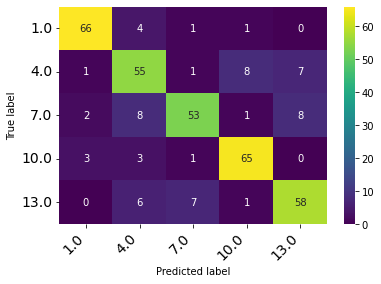

In [35]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.44642857142857145
The testing acc Score is 0.44166666666666665
The testing acc Score STD 0.028422229491222174
              precision    recall  f1-score   support

         1.0       0.52      0.62      0.57        72
         4.0       0.00      0.00      0.00        72
         7.0       0.25      0.33      0.29        72
        10.0       0.61      0.69      0.65        72
        13.0       0.44      0.56      0.49        72

    accuracy                           0.44       360
   macro avg       0.36      0.44      0.40       360
weighted avg       0.36      0.44      0.40       360



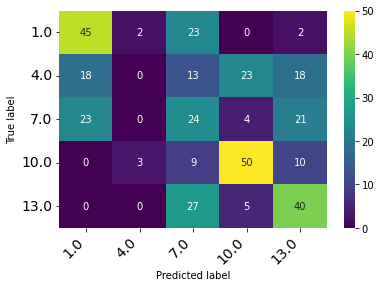

In [36]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9880952380952381
The testing acc Score is 0.8416666666666667
The testing acc Score STD 0.011293848786315635
              precision    recall  f1-score   support

         1.0       0.92      0.92      0.92        72
         4.0       0.83      0.67      0.74        72
         7.0       0.79      0.81      0.80        72
        10.0       0.81      0.96      0.88        72
        13.0       0.86      0.86      0.86        72

    accuracy                           0.84       360
   macro avg       0.84      0.84      0.84       360
weighted avg       0.84      0.84      0.84       360



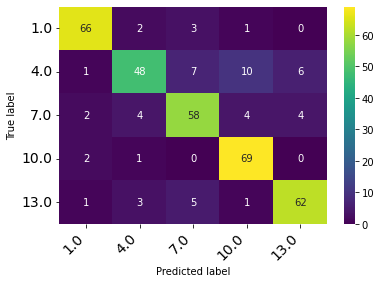

In [37]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 10)

#PCA Analysis

In [38]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed_x = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.78682768, 0.11379911])

In [39]:
pca_df = pd.DataFrame(data=np.c_[pca_transformed_x, Y['Group']],
                       columns=['x1','x2', 'Group'])
pca_df.head()

,x1,x2,Group
0,0.140545,0.178092,1.0
1,0.276846,0.064024,1.0
2,0.191713,-0.173420,1.0
3,0.163186,0.045119,1.0
4,0.045443,0.092347,1.0


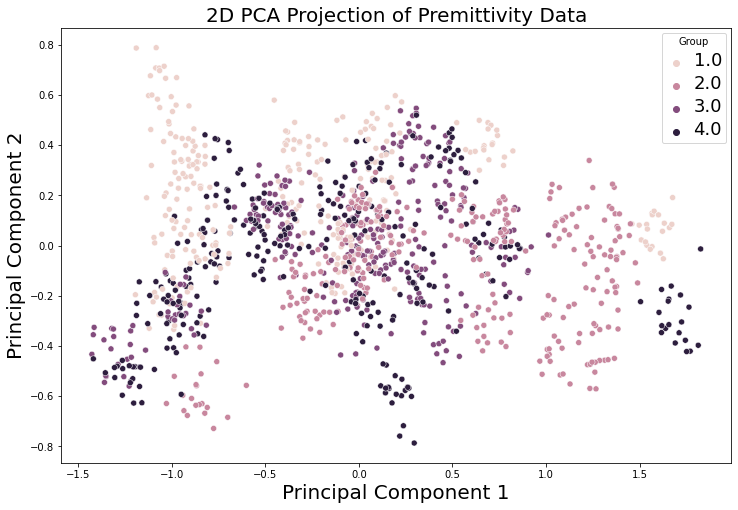

In [41]:

f, ax = plt.subplots(1,1, figsize=(12,8))
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='Group', ax=ax)
ax.set_xlabel("Principal Component 1", fontsize=20)
ax.set_ylabel("Principal Component 2", fontsize=20)
ax.set_title("2D PCA Projection of Premittivity Data", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

#ANN

In [49]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [50]:
X=df[['Average Zeroed Cap@174kHz', 'Average Zeroed Cap@224kHz', 'Average Zeroed Cap@287kHz', 'Average Zeroed Cap@368kHz', 'Average Zeroed Cap@473kHz', 'Average Zeroed Cap@607kHz', 'Average Zeroed Cap@779kHz', 'Average Zeroed Cap@1000kHz', 'Average Zeroed Cap@1284kHz', 'Average Zeroed Cap@1648kHz', 'Average Zeroed Cap@2115kHz']]
Y=df[['Group','Day']]

In [60]:
#Encoding the categorical Y
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
lb1=LabelBinarizer()
scaler=StandardScaler()
#Y=df[['Biomaterial','Time Period']]
X_transformed=scaler.fit_transform(X)
Y_transformed_group_ann = lb1.fit_transform(Y['Group'])

In [61]:
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_group_ann,
                                                test_size=0.3,
                                                random_state=42)

In [62]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb1.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                192       
                                                                 
 activation_18 (Activation)  (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 12)                204       
                                                                 
 activation_19 (Activation)  (None, 12)                0         
                                                                 
 dense_20 (Dense)            (None, 4)                 52        
                                                                 
 activation_20 (Activation)  (None, 4)                 0         
                                                                 
Total params: 448
Trainable params: 448
Non-trainable 

In [57]:
classes= np.unique(Y['Group'])
print(classes)

# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(classes)))
model.add(Activation("softmax"))
model.summary()

[1. 2. 3. 4.]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                192       
                                                                 
 activation_15 (Activation)  (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 12)                204       
                                                                 
 activation_16 (Activation)  (None, 12)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                 52        
                                                                 
 activation_17 (Activation)  (None, 4)                 0         
                                                                 
Total params: 448
Trainable params: 448


In [58]:
X.shape[1]

11

In [63]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
27/27 [==============================] - 1s 9ms/step - loss: 1.3721 - accuracy: 0.2917 - val_loss: 1.3276 - val_accuracy: 0.3417
Epoch 2/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.3022 - accuracy: 0.4000 - val_loss: 1.2847 - val_accuracy: 0.4056
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.2540 - accuracy: 0.4262 - val_loss: 1.2434 - val_accuracy: 0.4222
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.2130 - accuracy: 0.4500 - val_loss: 1.2040 - val_accuracy: 0.4361
Epoch 5/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.1795 - accuracy: 0.4583 - val_loss: 1.1708 - val_accuracy: 0.4389
Epoch 6/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.1523 - accuracy: 0.4702 - val_loss: 1.1435 - val_accuracy: 0.4444
Epoch 7/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.1303 - accuracy: 0.4940 - val_loss: 1.1151 - val_accuracy: 0.4611
Epoch 

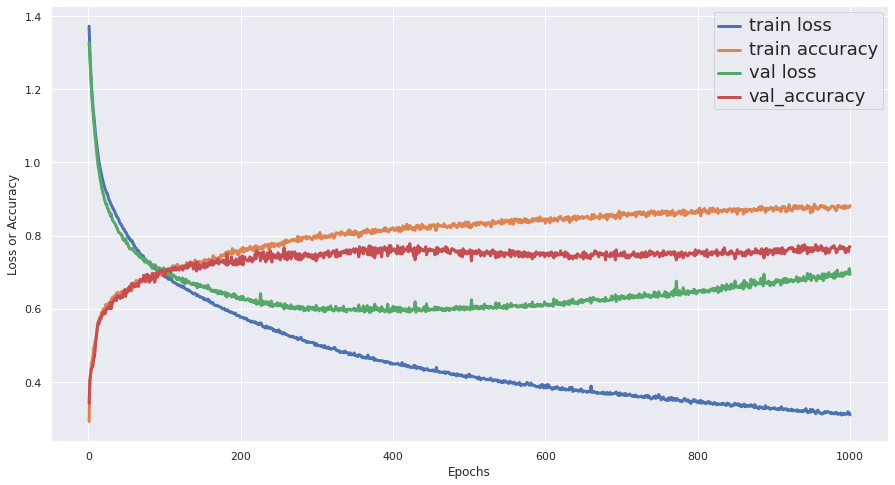

In [64]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [65]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        98
           1       0.88      0.82      0.85        89
           2       0.70      0.70      0.70        89
           3       0.62      0.71      0.67        84

    accuracy                           0.77       360
   macro avg       0.77      0.77      0.77       360
weighted avg       0.78      0.77      0.77       360



#ANN-Day

In [66]:
lb2=LabelBinarizer()
scaler=StandardScaler()
X_transformed=scaler.fit_transform(X)
Y_transformed_day_ann = lb2.fit_transform(Y['Day'])

In [67]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_day_ann,
                                                test_size=0.3,
                                                random_state=42)

In [68]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb2.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                192       
                                                                 
 activation_21 (Activation)  (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 12)                204       
                                                                 
 activation_22 (Activation)  (None, 12)                0         
                                                                 
 dense_23 (Dense)            (None, 5)                 65        
                                                                 
 activation_23 (Activation)  (None, 5)                 0         
                                                                 
Total params: 461
Trainable params: 461
Non-trainable 

In [69]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
27/27 [==============================] - 1s 9ms/step - loss: 1.4568 - accuracy: 0.3917 - val_loss: 1.4022 - val_accuracy: 0.4250
Epoch 2/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.3447 - accuracy: 0.4548 - val_loss: 1.3021 - val_accuracy: 0.5028
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.2539 - accuracy: 0.5036 - val_loss: 1.2140 - val_accuracy: 0.5472
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.1664 - accuracy: 0.5512 - val_loss: 1.1276 - val_accuracy: 0.5972
Epoch 5/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.0802 - accuracy: 0.5952 - val_loss: 1.0450 - val_accuracy: 0.6278
Epoch 6/1000
27/27 [==============================] - 0s 3ms/step - loss: 1.0027 - accuracy: 0.6262 - val_loss: 0.9714 - val_accuracy: 0.6806
Epoch 7/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.9351 - accuracy: 0.6607 - val_loss: 0.9070 - val_accuracy: 0.6861
Epoch 

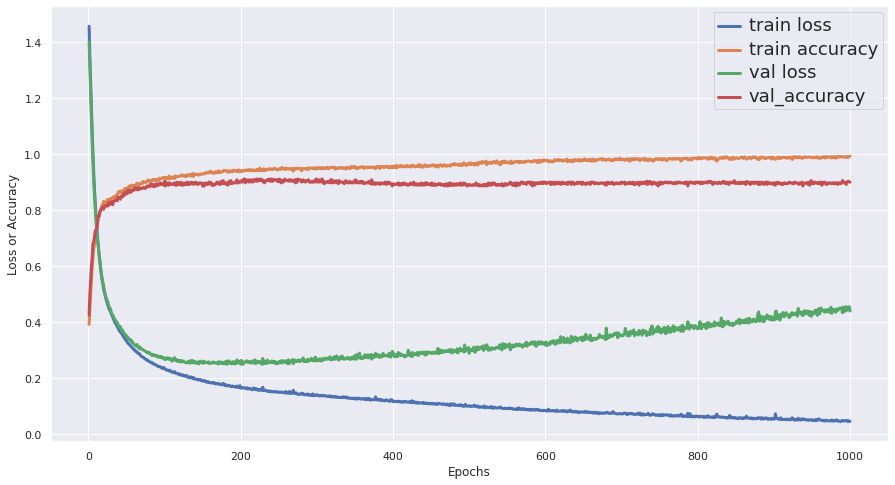

In [70]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [77]:
classes=np.unique(Y['Day'])
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
#print(classification_report(testy.argmax(axis=1), preds.argmax(axis=1), labels=classes))
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        71
           1       0.92      0.86      0.89        81
           2       0.78      0.93      0.85        67
           3       0.94      0.89      0.92        75
           4       0.92      0.85      0.88        66

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360

